In [1]:
import os
import os.path as osp
import pprint
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt
import scipy.io as sio

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.models.HT import hough_transform

from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to
import cv2
from IPython.display import Image, display
from scipy.spatial import distance as dist
from functools import cmp_to_key

In [2]:
REJECT_DEGREE_TH = 40.0

In [3]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [4]:
def c(x):
    return sm.to_rgba(x)

In [5]:
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'outdir': 'results/',
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 20000,
              'vote_index': 'vote_index_128_128_3_1.mat'},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 5,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
            

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = "cpu"
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(0)
print("Let's use", torch.cuda.device_count(), "GPU(s)!")

Let's use 0 GPU(s)!


In [7]:
device = torch.device(device_name)
checkpoint = torch.load("pretrained_models/ht_lcnn/checkpoint.pth.tar", map_location=device)


In [8]:
# Load model
if os.path.isfile(C.io.vote_index):
    vote_index = sio.loadmat(C.io.vote_index)['vote_index']
else:
    vote_index = hough_transform(rows=128, cols=128, theta_res=3, rho_res=1)
    sio.savemat(C.io.vote_index, {'vote_index': vote_index})
vote_index = torch.from_numpy(vote_index).float().contiguous().to(device)
print('load vote_index', vote_index.shape)

load vote_index torch.Size([128, 128, 182, 60])


In [9]:
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
    vote_index=vote_index,

)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

LineVectorizer(
  (backbone): MultitaskLearner(
    (backbone): HourglassNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck2D(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (layer2): Sequential(
        (0): Bottleneck2D(
          (bn

In [10]:
img = "pictures/05.jpg"
print(f"Processing {img}")
im = skimage.io.imread(img)
# cv2.imshow("img",im)
# cv2.waitKey(0) 
# display(Image(im))

Processing pictures/05.jpg


In [11]:
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
# cv2.imshow("img",image)
# cv2.waitKey(0) 
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

In [12]:
# cv2.imshow("img",image)
# cv2.waitKey(0) 

In [13]:
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

In [14]:
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()
print('lines: ',lines, ', scores: ', scores)
for i in range(1, len(lines)):
    if (lines[i] == lines[0]).all():
        lines = lines[:i]
        scores = scores[:i]
        break

lines:  [[[  30.22689009  383.60814452]
  [  49.91535582  384.06972289]]

 [[  30.22689009  383.60814452]
  [   2.80987517  415.34552574]]

 [[ 130.82459655  794.23868656]
  [  54.13813702  797.92921543]]

 ...

 [[ 362.87832159  775.8777678 ]
  [ 427.66825581  349.9882251 ]]

 [[ 281.281901     36.23759821]
  [ 257.12819132  443.90054047]]

 [[  46.7070749   969.20272112]
  [  15.21675611 1035.07992029]]] , scores:  [0.9991543 0.9991517 0.9990835 ... 0.6792506 0.679202  0.6783309]


In [15]:

# postprocess lines to remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

In [16]:
type(nlines)

numpy.ndarray

In [17]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

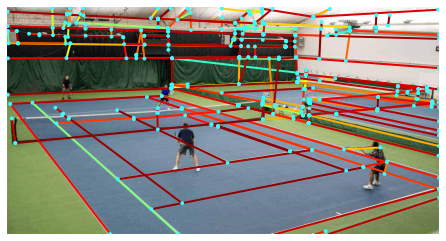

In [18]:
t = 0.94
im2 = np.copy(im)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
    cv2.line(im2, (int(a[1]), int(a[0])), (int(b[1]), int(b[0])), (255, 255, 255), thickness=2)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()


In [19]:
cv2.imshow("OutputImage", im2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('pictures/test.jpg', im2)


True

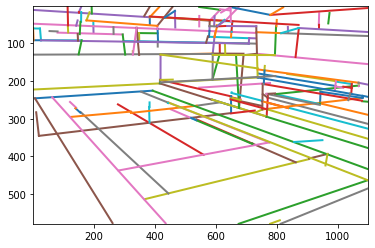

In [20]:
t = 0.94
plt.figure(1)
plt.margins(0, 0)
nlines2 = []
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    nlines2.append((a,b))
    plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
nlines2 = np.array(nlines2)
plt.gca().invert_yaxis()
plt.show()
plt.close()

(array([30.,  0.,  6., 10., 88., 35.,  7.,  5.,  6., 43.]), array([  0.24209723,  18.20700156,  36.17190588,  54.1368102 ,
        72.10171453,  90.06661885, 108.03152317, 125.9964275 ,
       143.96133182, 161.92623614, 179.89114047]), <BarContainer object of 10 artists>)


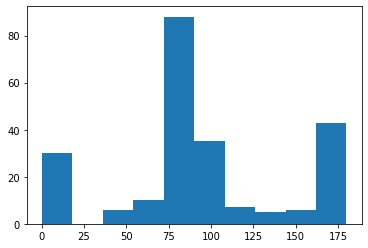

In [21]:
line_w_thetas = []
thetas=[]
for line in nlines2:
    if line[0][1]>line[1][1]:
        dy = line[0][1]-line[1][1]
        dx = line[0][0]-line[1][0]
    else:
        dy = line[1][1]-line[0][1]
        dx = line[1][0]-line[0][0]        

    theta = math.atan2(dy,dx)
    theta *= 180/math.pi
    line_w_thetas.append([line,theta])
    thetas.append(theta)
    # print (theta)
thetas.sort()
# print(thetas)
# np.gradient(thetas)
result = plt.hist(thetas)
print(result)

In [22]:
line_w_thetas[0][0]

array([[ 30.22689009, 383.60814452],
       [ 49.91535582, 384.06972289]])

In [23]:
res = np.copy(result[0])
print(res)
ind1=np.argmax(res)
res[ind1] =0
ind2 = np.argmax(res)
print(ind1,ind2)
print(result[1][ind1],result[1][ind2])
filter_th = [int(result[1][ind1]),int(result[1][ind2])]
print(filter_th)


[30.  0.  6. 10. 88. 35.  7.  5.  6. 43.]
4 9
72.10171452586657 161.9262361429707
[72, 161]


In [24]:
nlines2[0][0]

array([ 30.22689009, 383.60814452])

In [25]:
intersect_points = []
for i in range(len(nlines2)):
    for j in range(i+1,len(nlines2)):
        inter = get_intersect(nlines2[i][0],nlines2[i][1],nlines2[j][0],nlines2[j][1])
        if abs(inter[0])< im.shape[0] and abs(inter[1])< im.shape[1]:
            intersect_points.append(inter)

In [26]:
intersect_points[0]

(30.22689009457833, 383.6081445217132)

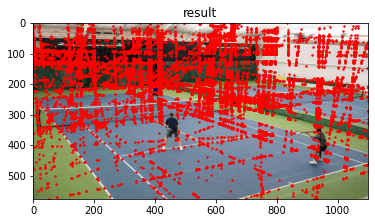

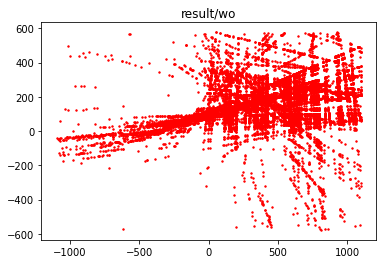

In [27]:
plt.figure(1)
plt.title('result')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)
# plt.gca().invert_yaxis()
plt.imshow(im)
plt.figure(2)
plt.title('result/wo')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)

In [28]:
def add_court_overlay(frame, homography, overlay_color=(255, 255, 255)):
    court_reference = cv2.imread("pictures/court_reference.png", 0)
    court = cv2.warpPerspective(court_reference, homography, (frame.shape[1],frame.shape[0]))
    # court = cv2.warpPerspective(court_reference, homography, frame.shape[1::-1])
    frame[court == 255, :] = overlay_color
    return frame

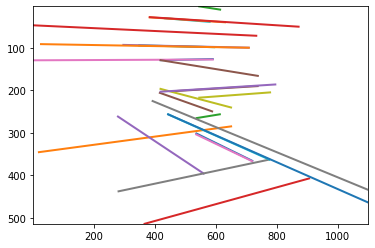

In [29]:
plt.figure(1)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
            ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
        plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
plt.gca().invert_yaxis()
 

In [30]:
# t = 0.94
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)

# new_nlines = np.zeros((2,2,2))
# new_nscores = np.zeros((2))
# bottom_1 = -1
# bottom_2 = -1
# for (a, b), s in zip(nlines, nscores):
#     if s < t:
#         continue
    
#     # is horizontal
#     # has a point in the middle of the image
#     if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
#             ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
#         min_bottom = min(bottom_1, bottom_2)
#         if a[0] > min_bottom and b[0] > min_bottom:
#             if(bottom_1 == min_bottom):
#                 bottom_1 = (a[0]+b[0])/2
#                 new_nlines[0][0] = a
#                 new_nlines[0][1] = b
#                 new_nscores[0] = s
#             else:
#                 bottom_2 = (a[0]+b[0])/2
#                 new_nlines[1][0] = a
#                 new_nlines[1][1] = b
#                 new_nscores[1] = s

# court_points = new_nlines.copy()
# if(court_points[0][0][0] > court_points[1][0][0]):
#     court_points = np.flip(court_points, 0)
# for i, p in enumerate(court_points):
#     court_points[i] = np.flip(court_points[i], 1)
# for i, p in enumerate(court_points):
#     court_points[i] = p[p[:, 0].argsort()]
# # print(court_points)
# court_points = court_points.reshape(-1, new_nlines.shape[-1])

# court_points_new = court_points

# print("----------------------------")
# print(court_points)
# print(court_points_new)
# print("----------------------------")

# template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
# # T, _, _ = best_fit_transform(template_points, court_points)
# T, status = cv2.findHomography(template_points, np.asarray(court_points_new))
# plt.imshow(im)
# plt.show()
# plt.imshow(T)
# plt.show()
# court = add_court_overlay(im, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
# # court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
# plt.imshow(court)
# plt.show()

In [31]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

In [32]:
def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [33]:
def FilterLines2(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line[0]
        theta = Line[1]
        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if  filter_th[0]-REJECT_DEGREE_TH<= theta <=filter_th[0]+REJECT_DEGREE_TH \
        or filter_th[1]-REJECT_DEGREE_TH<= theta <=filter_th[1]+REJECT_DEGREE_TH:
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, theta, l])

    
    return FinalLines

In [34]:
print(line_w_thetas[0][0])
[[x1, y1], [x2, y2]] = line_w_thetas[0][0]
print(x1,y1,x2,y2)

[[ 30.22689009 383.60814452]
 [ 49.91535582 384.06972289]]
30.226890094578266 383.60814452171326 49.91535582393408 384.0697228908539


In [35]:
LineSS = FilterLines2(line_w_thetas)
print(LineSS[0])

[30.226890094578266, 383.60814452171326, 2.809875172562897, 415.34552574157715, 130.82279532748282, 41.939886431999106]


In [36]:
# Drawing lines and vanishing point
im3 = np.copy(im)
lines32 = np.float32(LineSS)
print(lines32[0])
for Line in lines32:
    cv2.line(im3, (Line[1], Line[0]), (Line[3], Line[2]), (0, 255, 0), 2)
# cv2.circle(im3, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

# Showing the final image
cv2.imshow("OutputImage", im3)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 30.22689   383.60815     2.8098752 415.34552   130.8228     41.939888 ]


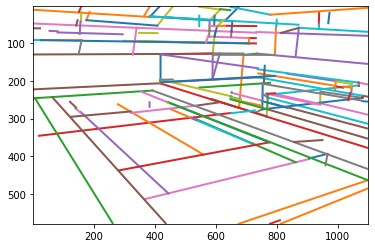

In [37]:
# Drawing lines and vanishing point
plt.figure(2)
plt.margins(0, 0)
lines32 = np.float32(LineSS)
for Line in lines32:
    # cv2.line(im, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    plt.plot((Line[1], Line[3]), (Line[0], Line[2]), linewidth=2)
# plt.scatter(VanishingPoint[0], VanishingPoint[1],**PLTOPTS)    
    # Showing the final imageplt.gca().invert_yaxis()
plt.gca().invert_yaxis()

In [38]:
GrayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#Blurring image to reduce noise.
BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
# Generating Edge image
EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

# Finding Lines in the image
Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

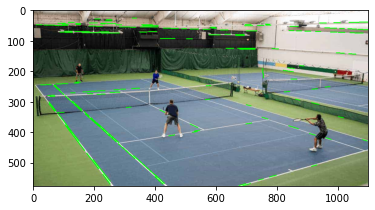

In [39]:
im4 = np.copy(im)
for Line in Lines:
    Line = Line[0]
    cv2.line(im4,(Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
# cv2.circle(im, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)
cv2.imshow("OutputImage", im4)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(im4)
plt.show()
plt.close()

In [40]:
def calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh):
    current_hypothesis = current_hypothesis / current_hypothesis[-1]
    hypothesis_vp_direction = current_hypothesis[:2] - lines[:,0]
    lines_vp_direction = lines[:,1] - lines[:,0]
    magnitude = np.linalg.norm(hypothesis_vp_direction, axis=1) * np.linalg.norm(lines_vp_direction, axis=1)
    magnitude[magnitude == 0] = 1e-5
    cos_theta = (hypothesis_vp_direction*lines_vp_direction).sum(axis=-1) / magnitude
    cos_theta = np.clip(cos_theta, -1, 1)
    theta = np.arccos(np.abs(cos_theta))
    inliers = (theta < ransac_angle_thresh * np.pi / 180)
    inliers[ignore_pts] = False
    return inliers, inliers.sum()

In [41]:
def run_line_ransac(lines, ransac_iter, ransac_angle_thresh, ignore_pts=None):
    best_vote_count = 0
    best_inliers = None
    best_hypothesis = None
    if ignore_pts is None:
        ignore_pts = np.zeros((lines.shape[0])).astype('bool')
        lines_to_chose = np.arange(lines.shape[0])
    else:
        lines_to_chose = np.where(ignore_pts==0)[0]
    for iter_count in range(ransac_iter):
        idx1, idx2 = np.random.choice(lines_to_chose, 2, replace=False)
        l1 = np.cross(np.append(lines[idx1][1], 1), np.append(lines[idx1][0], 1))
        l2 = np.cross(np.append(lines[idx2][1], 1), np.append(lines[idx2][0], 1))

        current_hypothesis = np.cross(l1, l2)
        if current_hypothesis[-1] == 0:
            continue
        inliers, vote_count = calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh)
        if vote_count > best_vote_count:
            best_vote_count = vote_count
            best_hypothesis = current_hypothesis
            best_inliers = inliers
    return best_hypothesis, best_inliers

In [42]:
def get_vp_inliers(nlines, iterations, threshold):

    best_hypothesis_1, best_inliers_1 = run_line_ransac(nlines, iterations, threshold)
    ignore_pts = best_inliers_1
    best_hypothesis_2, best_inliers_2 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    ignore_pts = np.logical_or(best_inliers_1, best_inliers_2)
    best_hypothesis_3, best_inliers_3 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    inlier_lines_list = [best_inliers_1, best_inliers_2, best_inliers_3]
    best_hypothesis_1 = best_hypothesis_1 / best_hypothesis_1[-1]
    best_hypothesis_2 = best_hypothesis_2 / best_hypothesis_2[-1]
    best_hypothesis_3 = best_hypothesis_3 / best_hypothesis_3[-1]
    hypothesis_list = [best_hypothesis_1, best_hypothesis_2, best_hypothesis_3]
    return inlier_lines_list, hypothesis_list

In [43]:
def visualize_inliers(image, lines, inlier_lines_list, colors, fig_name='detected_lines.png'):
    subplot_count = len(inlier_lines_list)

    fig, axes = plt.subplots(1, subplot_count, figsize=(15, 15), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(len(inlier_lines_list)):
        ax[i].imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            ax[i].plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])
        ax[i].set_xlim((0, image.shape[1]))
        ax[i].set_ylim((image.shape[0], 0))
        ax[i].set_title('RANSAC {} Inliers'.format(str(i)))

    for a in ax:
        a.set_axis_off()

    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

    plt.figure(8)
    for i in range(len(inlier_lines_list)):
        plt.imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])


    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

In [44]:
def visualize_vanishing_points(vp1, vp2, vp3, image, lines, inlier_lines_list, colors):
    vps = [vp1, vp2, vp3]
    for i in range(len(inlier_lines_list)):
        plt.imshow(image)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])

        plt.plot([vps[i][0]], [vps[i][1]], colors[i]+'X', markersize=5)
        plt.axis('off')
        plt.tight_layout()
        plt.close()

    plt.imshow(image)
    for i in range(len(inlier_lines_list)):
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])

    plt.plot([vps[0][0]], [vps[0][1]], colors[0]+'X', markersize=5)
    plt.plot([vps[1][0]], [vps[1][1]], colors[1]+'X', markersize=5)
    plt.plot([vps[2][0]], [vps[2][1]], colors[2]+'X', markersize=5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close() 

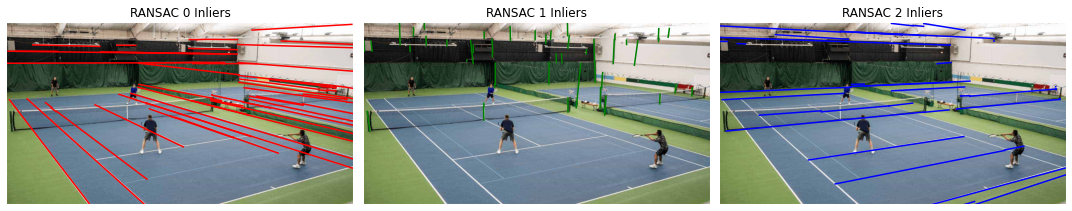

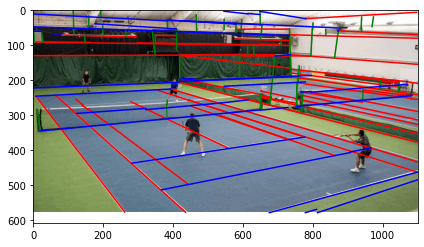

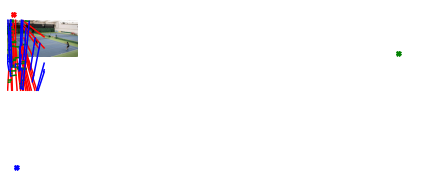

In [45]:
inlier_lines_list, hypothesis_list = get_vp_inliers(nlines2,1000, 5)
best_hypothesis_1, best_hypothesis_2, best_hypothesis_3 = hypothesis_list
colors = ['r', 'g', 'b']
visualize_inliers(im, nlines2, inlier_lines_list, colors)
visualize_vanishing_points(best_hypothesis_1, best_hypothesis_2, best_hypothesis_3,
                               im, nlines2, inlier_lines_list, colors)

In [46]:
def rotateHToLine(H, line):
    assert len(line) == 3
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Compute transformed line = H^-T * l
    lineTr = np.dot(np.linalg.inv(H).T, line)

    # Rotate so that this line is horizonal in the image 
    r1 = np.array([lineTr[1], -lineTr[0]]) # First row of R is perpendicular to linesTr[0]
    r1 = r1 / np.linalg.norm(r1.flatten())
    theta = np.arctan2(-r1[1] , r1[0])
    if abs(theta) < pi/4:
        R = np.array([[r1[0],  r1[1]], [-r1[1], r1[0]]])
    else:
        R = np.identity(2)
        #R = np.array([[r1[1], -r1[0]], [ r1[0], r1[1]]])
    theta = np.arctan2(R[1,0], R[1,1])
    print("Rotating by %.1f degrees" % (theta*180/pi))
    HR = np.identity(3)
    HR[0:2,0:2] = R

    return np.dot(HR,H)

In [47]:
def translateHToPosQuadrant(H, limits):
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)

    # Check if corners map to infinity, if so skip translation
    if not finite:
        print("Corners map to infinity, skipping translation")
        return H

    # Min coordinates of H * image corners
    minc = [min([Hcor[j][i]/Hcor[j][2] for j in range(len(Hcor))]) for i in range(2)]

    # Choose translation
    HT = np.identity(3)
    HT[0,2] = -minc[0]
    HT[1,2] = -minc[1]

    return np.dot(HT, H)

In [48]:
def scaleHToImage(H, limits, anisotropic = False): # TODO: test anisotropic
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)

    # If corners in the transformed image are not finite, don't do scaling
    if not finite:
        print("Skipping scaling due to point mapped to infinity")
        return H;
        
    # Maximum coordinate that any corner maps to
    k = [max([Hcor[j][i] / Hcor[j][2] for j in range(len(Hcor))])/float(limits[1-i]) for i in range(2)];

    # Scale
    if anisotropic:
        print("Scaling by (%f,%f)\n" % (k[0], k[1]))
        HS = np.array([[1./k[0],0.0,0.0],[0.0,1./k[1],0.0],[0.0,0.0,1.0]])
    else:
        k = max(k)
        print("Scaling by %f\n" % k)
        HS = np.array([[1.0/k,0.0,0.0],[0.0,1.0/k,0.0],[0.0,0.0,1.0]])

    return np.dot(HS, H)

In [49]:
def getHCorners(H, limits):
    Ny = float(limits[0])
    Nx = float(limits[1])
    # Apply H to corners of the image to determine bounds
    Htr  = np.dot(H, np.array([0.0, Ny, 1.0]).flatten()) # Top left maps to here
    Hbr  = np.dot(H, np.array([Nx,  Ny, 1.0]).flatten()) # Bottom right maps to here
    Hbl  = np.dot(H, np.array([Nx, 0.0, 1.0]).flatten()) # Bottom left maps to here
    Hcor = [Htr,Hbr,Hbl]
    
    # Check if corners in the transformed image map to infinity finite
    finite = True 
    for y in Hcor:
        if y[2] == 0:
            finite = False

    return Hcor, finite

In [50]:
vLine = np.cross(best_hypothesis_1, best_hypothesis_2)
print(best_hypothesis_1,best_hypothesis_2)
print("Vanishing line:")
print(vLine)
H = np.identity(3)
H[2,0] = vLine[0] / vLine[2]
H[2,1] = vLine[1] / vLine[2]

print("H:")
print(H)



[ 87.28756934 -93.3299273    1.        ] [6.12481558e+03 5.14855811e+02 1.00000000e+00]
Vanishing line:
[-6.08185738e+02  6.03752801e+03  6.16569105e+05]
H:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-9.86403199e-04  9.79213516e-03  1.00000000e+00]]


In [51]:

# H = rotateHToLine(H, [inlier_lines_list[0],1])
H = translateHToPosQuadrant(H, im.shape)
H = scaleHToImage(H, im.shape, False)


Scaling by 11.938380



In [52]:
result = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
cv2.imshow('output',result) 
cv2.imwrite('output.png',result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [53]:
im_cv = cv2.imread(img)
padding = 100
im_cv= cv2.copyMakeBorder(im_cv,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
list1 = []      # separate lists to store the coordinates for the separate lines
list2 = []
check = 0       # variable to switch between the lists

def getPoints(event, x, y, flags, params):
    
    global list1, list2, check    
   
    if event == cv2.EVENT_LBUTTONDOWN:
        print (x,y)
        if check < 4:
            list1.append([x, y])
            check += 1
        else:
            list2.append([x, y])
    elif event == cv2.EVENT_LBUTTONUP:                   
        cv2.circle(im_cv,(x,y), 4, (0,255,0), -1)
        cv2.imshow("image", im_cv)

    
cv2.namedWindow("image")
cv2.setMouseCallback("image", getPoints)

def selectPoints():
    global check
    while True:
        cv2.imshow("image", im_cv)
        key = cv2.waitKey(1) & 0xFF        
        
        if key == ord("q"):
            break
#         elif check == 7:
#             break
        
selectPoints()
cv2.destroyAllWindows()
cv2.waitKey(1)

107 348
499 322
1250 548
412 766


-1

In [54]:
width_AD = np.sqrt(((list1[0][0] - list1[3][0]) ** 2) + ((list1[0][1] - list1[3][1]) ** 2))
width_BC = np.sqrt(((list1[1][0] - list1[2][0]) ** 2) + ((list1[1][1] - list1[2][1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((list1[0][0] - list1[1][0]) ** 2) + ((list1[0][1] - list1[1][1]) ** 2))
height_CD = np.sqrt(((list1[2][0] - list1[3][0]) ** 2) + ((list1[2][1] - list1[3][1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

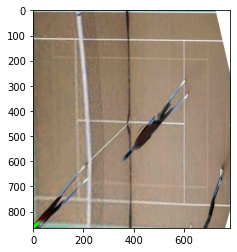

In [55]:
width , height = 350 , 550
list11 = np.float32(list1) 
# list22 = np.float32([[0,0],[width,0],[0,height],[width,height]])
matrix = cv2.getPerspectiveTransform(list11,output_pts)
output = cv2.warpPerspective(im_cv,matrix,(maxWidth,maxHeight))
# cv2.imshow('output',output) 
cv2.imwrite('output.png',output)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(output)
plt.show()
plt.close()

In [56]:
print(matrix)

[[-4.34535478e-01 -6.55145798e+00  2.32640267e+03]
 [-1.99975845e+00  1.45915389e+00 -2.93811400e+02]
 [ 3.22926448e-05 -6.10969431e-03  1.00000000e+00]]


(2408, 1127)


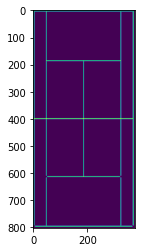

In [57]:
template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
court_reference = cv2.imread("pictures/court_reference.png", 0)
print(court_reference.shape)
for c in template_points:
    cv2.circle(court_reference, (int(c[0]), int(c[1])), 10, (0,255,0), cv2.FILLED)
imS = cv2.resize(court_reference, (int(court_reference.shape[1]/3), int(court_reference.shape[0]/3)))
# cv2.imshow("Court", imS)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(imS)
plt.show()
plt.close()

In [58]:
court_reference.shape

(2408, 1127)

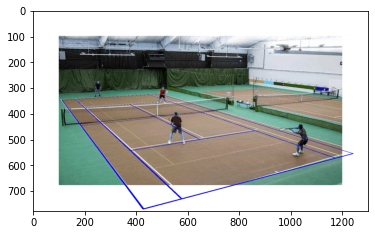

In [127]:
im5 = np.copy(im)
padding = 100
im5= cv2.copyMakeBorder(im5,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
# list1 = np.asarray([[219, 702],[1769, 707],[1186, 194],[794, 198]]) 
factor_s = 2.11
template_try= np.asarray([[0, 0], [2408/factor_s, 0], [2408/factor_s, 1127*factor_s], [0, 1127*factor_s]])
T, status = cv2.findHomography(template_try, np.asarray(list1))
court = add_court_overlay(im5, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", court)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(court)
plt.show()
plt.close()

In [60]:
def intersect(a1, a2, b1, b2):
    x1,y1 = a1
    x2,y2 = a2
    x3,y3 = b1
    x4,y4 = b2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return [x,y]

In [61]:
inlier_1 = 0
inlier_2 = 2

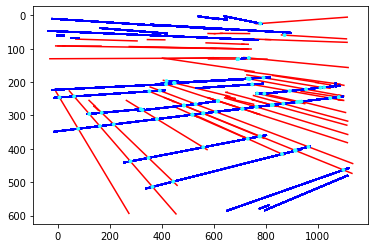

In [62]:
s_factor = 1.1
section = []
section_ind = []
inter_pts = []
for i,line1 in enumerate(nlines2[inlier_lines_list[inlier_1]]):
    a0,a1 = line1
    a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
    a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
    plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), 'r')
    counter = 0
    for j,line2 in enumerate(nlines2[inlier_lines_list[inlier_2]]):
        b0,b1 = line2
        b0 = [b0[0] *(1+s_factor)/2 + b1[0] *(1-s_factor)/2 , b0[1] *(1+s_factor)/2 + b1[1] *(1-s_factor)/2]
        b1 = [b1[0] *(1+s_factor)/2 + b0[0] *(1-s_factor)/2 , b1[1] *(1+s_factor)/2 + b0[1] *(1-s_factor)/2]
        plt.plot((b0[1], b1[1]),(b0[0], b1[0] ), 'b')
        intersect_pt = intersect(a0,a1,b0,b1)
        # print (intersect_pt)
        if intersect_pt is not None:
            plt.scatter(intersect_pt[1],intersect_pt[0],**PLTOPTS)
            if(counter==0):
                section.append([line1,line2])
                section_ind.append([i,j+len(inlier_lines_list[inlier_1])])
                inter_pts.append([intersect_pt])
            else:
                section[-1].append(line2)
                section_ind[-1].append(j+len(inlier_lines_list[inlier_1]))
                inter_pts[-1].append(intersect_pt)
            counter +=1
            
plt.gca().invert_yaxis()
  
# for i in range(len(inlier_lines_list)-1):
#     plt.imshow(im)
#     for line in nlines2[inlier_lines_list[i]]:
#         p0, p1 = line
#         plt.plot((p0[1], p1[1]),(p0[0], p1[0] ), colors[i])

In [63]:
for i , n in enumerate(inter_pts):
    print(i,':', len(n))

0 : 4
1 : 2
2 : 4
3 : 1
4 : 1
5 : 1
6 : 1
7 : 1
8 : 1
9 : 1
10 : 1
11 : 1
12 : 1
13 : 2
14 : 1
15 : 2
16 : 1
17 : 1
18 : 1
19 : 1
20 : 4
21 : 2
22 : 2
23 : 3
24 : 1
25 : 3
26 : 6
27 : 1
28 : 3
29 : 3
30 : 1
31 : 2
32 : 1
33 : 1
34 : 1
35 : 5
36 : 1


In [64]:

merge_sec = section[0]
print(section_ind[0])
for current_sec in section_ind[1:]:
    print(current_sec)
    # for line in current_sec:
        # print(line)
    

[3, 230, 236, 252, 255]
[4, 232, 236]
[5, 230, 232, 236, 255]
[7, 231]
[15, 245]
[16, 245]
[19, 245]
[22, 245]
[23, 268]
[29, 241]
[33, 244]
[35, 237]
[36, 235]
[38, 245, 247]
[39, 245]
[41, 230, 241]
[42, 247]
[43, 235]
[45, 230]
[46, 233]
[48, 230, 241, 250, 252]
[50, 231, 262]
[51, 231, 262]
[54, 233, 259, 268]
[55, 270]
[56, 230, 236, 252]
[58, 230, 232, 236, 246, 250, 252]
[59, 230]
[60, 238, 245, 247]
[65, 233, 247, 268]
[66, 245]
[68, 245, 260]
[70, 247]
[71, 245]
[85, 245]
[87, 230, 232, 236, 241, 255]
[89, 235]


In [65]:
merged_ind = section_ind
out = []
while len(merged_ind)>0:
    first, *rest = merged_ind
    first = set(first)

    lf = -1
    while len(first)>lf:
        lf = len(first)

        rest2 = []
        for r in rest:
            if len(first.intersection(set(r)))>0:
                first |= set(r)
            else:
                rest2.append(r)     
        rest = rest2

    out.append(first)
    merged_ind = rest

print(out)

[{3, 4, 5, 87, 29, 58, 230, 232, 41, 236, 45, 48, 241, 246, 56, 250, 59, 252, 255}, {50, 51, 7, 262, 231}, {65, 66, 259, 260, 68, 70, 71, 268, 15, 16, 19, 85, 22, 23, 38, 39, 233, 42, 238, 46, 245, 54, 247, 60}, {33, 244}, {35, 237}, {36, 89, 43, 235}, {270, 55}]


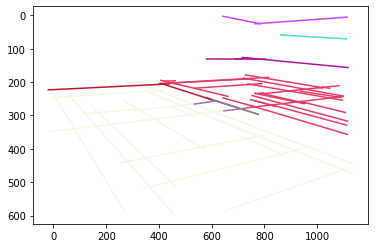

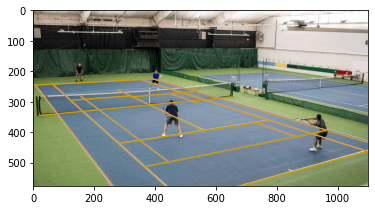

In [66]:
plt.figure(11)
target_lines = [[],[]]
for sec in out:
    # sec = out[0]
    r = np.random.rand(3,)
    for line1 in sec:
        if line1< len(inlier_lines_list[inlier_1]):      
            a0,a1 = nlines2[inlier_lines_list[inlier_1]][line1]
        else:
            line1-= len(inlier_lines_list[0])
            a0,a1 = nlines2[inlier_lines_list[2]][line1]
        a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
        a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
        plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=r)
plt.gca().invert_yaxis()

plt.figure(12)

sec = out[0]
r = np.random.rand(3,)
for line1 in sec:
    if line1< len(inlier_lines_list[inlier_1]):      
        a0,a1 = nlines2[inlier_lines_list[inlier_1]][line1]
        cc = [0.8,0.6,0.3]
        target_lines[0].append([a0,a1])
    else:
        line1-= len(inlier_lines_list[0])
        a0,a1 = nlines2[inlier_lines_list[2]][line1]
        target_lines[1].append([a0,a1])
        cc = r
    plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=cc)
plt.gca().invert_yaxis()
plt.imshow(im)

In [67]:
def find_line_eq (line):
    x_f = 0
    x_e = im.shape[1]
    y_f = 0
    y_e = im.shape[0]
    y_coords, x_coords = zip(*line)
    # print(x_coords)
    print('y coords: ', y_coords, 'x coords: ',x_coords)
    plt.plot(x_coords,y_coords, c='r')
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords,rcond=None)[0]
    print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    x0 = (y_f-c)/m
    x1 = (y_e-c)/m

    if x0 > x_e or x0< x_f:
        x0 = np.clip(x0,0,x_e)
        y0 = (m * x0) + c
    else:
        y0 = y_f

    if x1 > x_e or x1< x_f:
        x1 = np.clip(x1,0,x_e)
        y1 = (m * x1) + c
    else:
        y1 = y_e

    print("new line before clipping:", [x0,y0],[x1,y1])
    # x0 = np.clip(x0,0,x_e)
    # x1 = np.clip(x1,0,x_e)
    # y0 = np.clip(y0,0,y_e)
    # y1 = np.clip(y1,0,y_e)
    # print("New Line Solution is",[x0,y0],[x1,y1])
    plt.plot((x0,x1),(y0,y1), c=cc)
    plt.imshow(im)
    plt.show()
    
    # plt.gca().invert_yaxis()
    return [[y0,x0],[y1,x1]]

------------------
y coords:  (395.7313369512558, 261.7957025170326) x coords:  (560.6302678585052, 279.43495512008667)
Line Solution is y = 0.47630820417983466x + 128.69854085871137
new line before clipping: [0.0, 128.69854085871137] [941.2003723791165, 577]


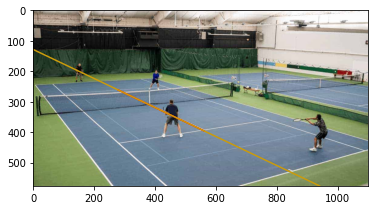

y coords:  (415.6792808175087, 365.7773730563374) x coords:  (862.5670373439789, 720.0251149065379)
Line Solution is y = 0.3500858337523291x + 113.70678038166552
new line before clipping: [0.0, 113.70678038166552] [1100.0, 498.8011975092275]


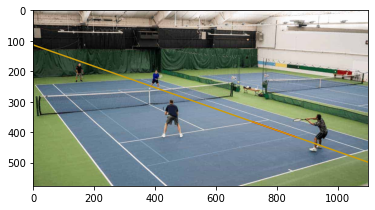

y coords:  (498.6681942343712, 282.2389066517353) x coords:  (445.1058238744736, 156.98985159397125)
Line Solution is y = 0.7511880923141815x + 164.30999952017365
new line before clipping: [0.0, 164.30999952017365] [549.3830436108942, 577]


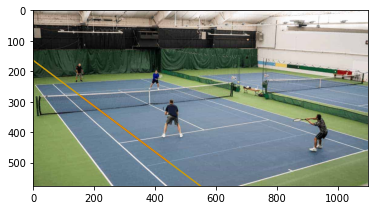

y coords:  (242.84632688760757, 577.6564722061157) x coords:  (63.691455125808716, 435.7544034719467)
Line Solution is y = 0.8998749991279086x + 185.53197876181517
new line before clipping: [0.0, 185.53197876181517] [435.0248885873775, 577]


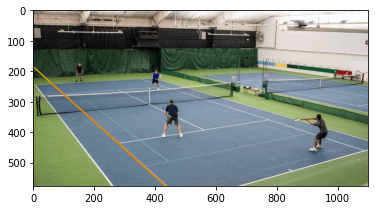

y coords:  (228.31077075004578, 257.12819132208824) x coords:  (355.4975628852844, 443.90054047107697)
Line Solution is y = 0.32597794055156154x + 112.42640732960159
new line before clipping: [0.0, 112.42640732960159] [1100.0, 471.0021419363193]


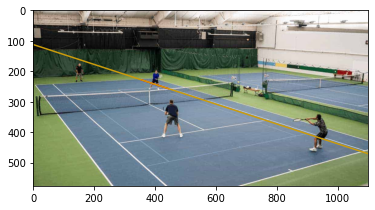

y coords:  (463.29047095775604, 256.6197664456529) x coords:  (1098.8412022590637, 444.0610165051577)
Line Solution is y = 0.31563371801506945x + 116.45913678057876
new line before clipping: [0.0, 116.45913678057876] [1100.0, 463.6562265971552]


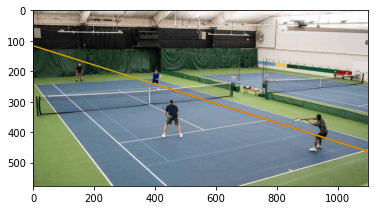

y coords:  (577.1081968545914, 245.72836643457413) x coords:  (261.64304316043854, 7.240111194550991)
Line Solution is y = 1.3025786607854488x + 236.29755209083814
new line before clipping: [0.0, 236.29755209083814] [261.55997957445413, 577]


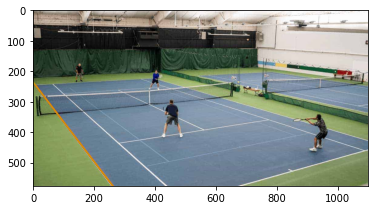

y coords:  (298.16900193691254, 274.8715296983719) x coords:  (519.470688700676, 452.69767343997955)
Line Solution is y = 0.3489054994383923x + 116.92282185219763
new line before clipping: [0.0, 116.92282185219763] [1100.0, 500.7188712344291]


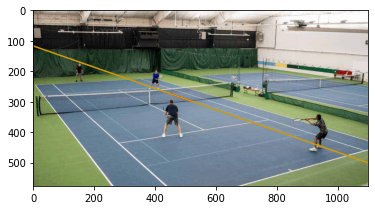

y coords:  (433.7075043320656, 225.37599125504494) x coords:  (1099.0569114685059, 393.1003659963608)
Line Solution is y = 0.29510529283029496x + 109.36999263599287
new line before clipping: [0.0, 109.36999263599287] [1100.0, 433.98581474931734]


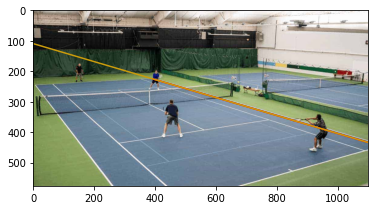

y coords:  (256.6575948793593, 362.8783215880394) x coords:  (444.0511826992089, 775.8777678012848)
Line Solution is y = 0.3201091518209871x + 114.51274742040948
new line before clipping: [0.0, 114.51274742040948] [1100.0, 466.6328144234953]


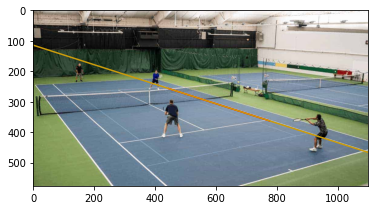

y coords:  (303.51500626054633, 297.84873070370514) x coords:  (536.0743584962186, 519.5807156411297)
Line Solution is y = 0.34354300057448195x + 119.35041261171479
new line before clipping: [0.0, 119.35041261171479] [1100.0, 497.2477132436449]


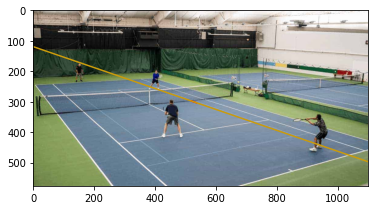

------------------
y coords:  (284.9166584312916, 345.4629957675934) x coords:  (650.5090832710266, 20.178543403744698)
Line Solution is y = -0.09605490057494269x + 347.40124374798717
new line before clipping: [1100.0, 241.7408531155502] [0.0, 347.40124374798717]


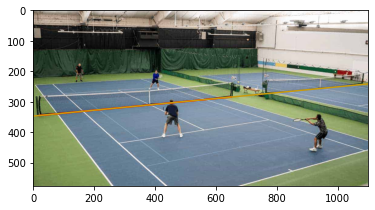

y coords:  (513.7299461364746, 407.18211340904236) x coords:  (366.83399975299835, 906.3597440719604)
Line Solution is y = -0.19748424213181273x + 586.173880565877
new line before clipping: [1100.0, 368.94121422088296] [46.45373457064882, 577]


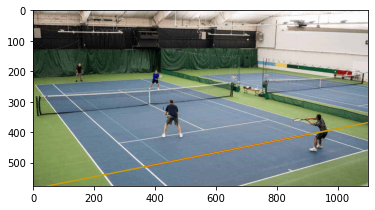

y coords:  (437.4408460855484, 362.8783215880394) x coords:  (281.4049571752548, 775.8777678012848)
Line Solution is y = -0.1507919604378417x + 479.87445125493207
new line before clipping: [1100.0, 314.00329477330615] [0.0, 479.87445125493207]


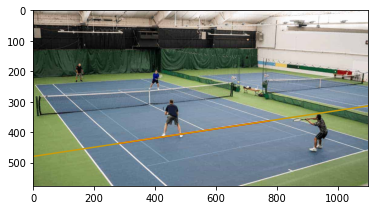

y coords:  (245.72836643457413, 225.37599125504494) x coords:  (7.240111194550991, 393.1003659963608)
Line Solution is y = -0.05274545622736626x + 246.11024940266768
new line before clipping: [1100.0, 188.0902475525648] [0.0, 246.11024940266768]


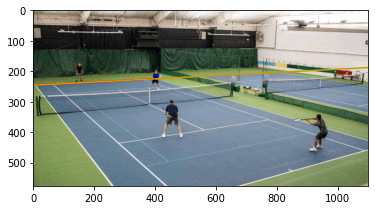

y coords:  (463.29047095775604, 579.0948781967163) x coords:  (1098.8412022590637, 675.476211309433)
Line Solution is y = -0.27353326258556343x + 763.8600900751212
new line before clipping: [1100.0, 462.9735012310014] [683.1347979724032, 577]


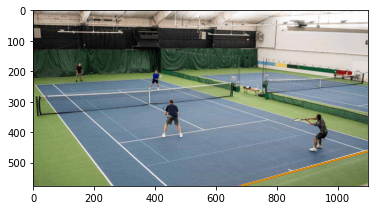

y coords:  (405.6804047375499, 393.53985196352005) x coords:  (906.0588326090924, 966.6466653347015)
Line Solution is y = -0.20037938688139245x + 587.23591809423
new line before clipping: [1100.0, 366.81859252469826] [51.08268995896659, 577]


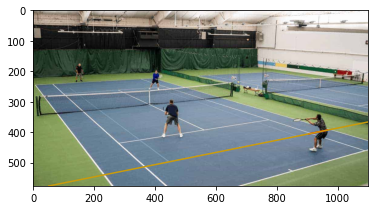

y coords:  (265.37584564089775, 284.4526087939739) x coords:  (537.6890361309052, 321.99326753616333)
Line Solution is y = -0.08844291789941627x + 312.9306329188395
new line before clipping: [1100.0, 215.64342322948158] [0.0, 312.9306329188395]


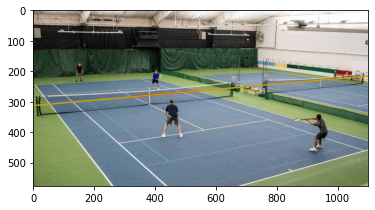

y coords:  (280.9416278501365, 295.11596596241) x coords:  (321.74019294726133, 125.09527802467346)
Line Solution is y = -0.0720808779512728x + 304.13294342998705
new line before clipping: [1100.0, 224.84397768358696] [0.0, 304.13294342998705]


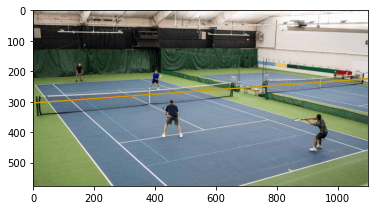

In [68]:
target_lines_span = [[],[]]
for i, parallel_lines in enumerate(target_lines):
    print('------------------')
    for line in parallel_lines:
        new_line = find_line_eq(line)
        target_lines_span[i].append(new_line)

# for line in target_lines[1]:
#     new_line = find_line_eq(line)
#     target_lines_span[1].append(new_line)

In [69]:
target_lines_span

[[[[128.69854085871137, 0.0], [577, 941.2003723791165]],
  [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]],
  [[164.30999952017365, 0.0], [577, 549.3830436108942]],
  [[185.53197876181517, 0.0], [577, 435.0248885873775]],
  [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]],
  [[116.45913678057876, 0.0], [463.6562265971552, 1100.0]],
  [[236.29755209083814, 0.0], [577, 261.55997957445413]],
  [[116.92282185219763, 0.0], [500.7188712344291, 1100.0]],
  [[109.36999263599287, 0.0], [433.98581474931734, 1100.0]],
  [[114.51274742040948, 0.0], [466.6328144234953, 1100.0]],
  [[119.35041261171479, 0.0], [497.2477132436449, 1100.0]]],
 [[[241.7408531155502, 1100.0], [347.40124374798717, 0.0]],
  [[368.94121422088296, 1100.0], [577, 46.45373457064882]],
  [[314.00329477330615, 1100.0], [479.87445125493207, 0.0]],
  [[188.0902475525648, 1100.0], [246.11024940266768, 0.0]],
  [[462.9735012310014, 1100.0], [577, 683.1347979724032]],
  [[366.81859252469826, 1100.0], [577, 51.0826899

In [70]:
mid_pts = []
for vert in target_lines[0]:
    mid_pts.append((vert[0][1]+vert[1][1])/2)
    
print(mid_pts)
l1 = np.argmin(mid_pts)
l2 = np.argmax(mid_pts)
print(l1,l2)
mid_pts = []
for hor in target_lines[1]:
    print(hor)
    mid_pts.append((hor[0][0]+hor[1][0])/2)
print(mid_pts)
l3 = np.argmin(mid_pts)
l4 = np.argmax(mid_pts)
print(l3,l4)

[420.03261148929596, 791.2960761252584, 301.0478377342224, 249.72292929887772, 399.6990516781807, 771.4511093821106, 134.44157717749476, 486.08418107032776, 746.0786387324333, 609.9644752502468, 527.8275370686741]
6 1
[array([284.91665843, 650.50908327]), array([345.46299577,  20.1785434 ])]
[array([513.72994614, 366.83399975]), array([407.18211341, 906.35974407])]
[array([437.44084609, 281.40495718]), array([362.87832159, 775.8777678 ])]
[array([245.72836643,   7.24011119]), array([225.37599126, 393.100366  ])]
[array([ 463.29047096, 1098.84120226]), array([579.0948782 , 675.47621131])]
[array([405.68040474, 906.05883261]), array([393.53985196, 966.64666533])]
[array([265.37584564, 537.68903613]), array([284.45260879, 321.99326754])]
[array([280.94162785, 321.74019295]), array([295.11596596, 125.09527802])]
[315.1898270994425, 460.4560297727585, 400.1595838367939, 235.55217884480953, 521.1926745772362, 399.610128350535, 274.91422721743584, 288.0287969062732]
3 4


In [71]:
# check if left
def check_side (line1,line2):
    x_1 = line1[0][0]
    x_2 = line1[1][0]
    y_1 = line1[0][1]
    y_2 = line1[1][1]
    fx = x_2 - x_1
    fy = y_2 -y_1
    check = []
    for pt in line2:
        torque = fx*(pt[1]-y_1)-fy*(pt[0]-x_1)
        if  torque>0:
            # "point on left side"
            check.append(1)
        else:
            check.append(0)
    # print(check)
    # print(all(check))
    if all(check) == True:
        return 1
    else:
        return -1
    # return all(check)

In [72]:
# def make_comparator(less_than):
#     def compare(x, y):
#         if less_than(x, y):
#             return -1
#         elif less_than(y, x):
#             return 1
#         else:
#             return 0
#     return compare

[[[[109.36999263599287, 0.0], [433.98581474931734, 1100.0]], [[114.51274742040948, 0.0], [466.6328144234953, 1100.0]], [[116.45913678057876, 0.0], [463.6562265971552, 1100.0]], [[112.42640732960159, 0.0], [471.0021419363193, 1100.0]], [[119.35041261171479, 0.0], [497.2477132436449, 1100.0]], [[113.70678038166552, 0.0], [498.8011975092275, 1100.0]], [[116.92282185219763, 0.0], [500.7188712344291, 1100.0]], [[128.69854085871137, 0.0], [577, 941.2003723791165]], [[164.30999952017365, 0.0], [577, 549.3830436108942]], [[185.53197876181517, 0.0], [577, 435.0248885873775]], [[236.29755209083814, 0.0], [577, 261.55997957445413]]], [[[462.9735012310014, 1100.0], [577, 683.1347979724032]], [[366.81859252469826, 1100.0], [577, 51.08268995896659]], [[368.94121422088296, 1100.0], [577, 46.45373457064882]], [[314.00329477330615, 1100.0], [479.87445125493207, 0.0]], [[241.7408531155502, 1100.0], [347.40124374798717, 0.0]], [[224.84397768358696, 1100.0], [304.13294342998705, 0.0]], [[215.6434232294815

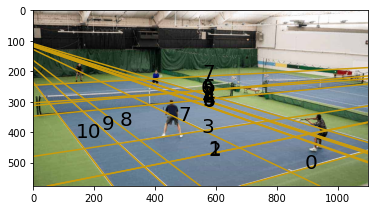

In [73]:
your_key = cmp_to_key(check_side)
# trial = sorted(target_lines[0], key=make_comparator(check_side), reverse=True)
borders = []
for i in range(len(target_lines_span)):
   borders.append(sorted(target_lines_span[i], key=your_key))
# trial2 = sorted(target_lines_span[1], key=your_key)
# trial = target_lines_span[0].sort(key=your_key)
print(borders)
num = 1
for border in borders:
   for i, vert in enumerate(border):
      plt.plot((vert[0][1], vert[1][1]),(vert[0][0], vert[1][0] ), c=cc)
      plt.text((vert[0][1]+vert[1][1])/2+(i*num),(vert[0][0]+vert[1][0])/2+(i*num),str(i),fontsize=20)
plt.imshow(im)

In [74]:
len(borders)

2

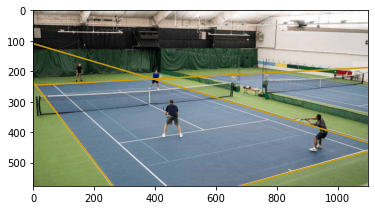

In [75]:
borders_filtered = []
for i in borders:
    borders_filtered.append(i[0])
    borders_filtered.append(i[-1])
    plt.plot((i[0][0][1], i[0][1][1]),(i[0][0][0], i[0][1][0] ), c=cc)
    plt.plot((i[-1][0][1], i[-1][1][1]),(i[-1][0][0], i[-1][1][0] ), c=cc)
# plt.plot((borders[1][0][0][1], borders[1][0][1][1]),(borders[1][0][0][0], borders[1][0][1][0] ), c=cc)
# plt.plot((borders[1][-1][0][1], borders[1][-1][1][1]),(borders[1][-1][0][0], borders[1][-1][1][0] ), c=cc)
plt.imshow(im)

In [76]:
borders_filtered[0][0]

[109.36999263599287, 0.0]

In [77]:
def order_points3(pts):
	# sort the points based on their x-coordinates
	xSorted = pts[np.argsort(pts[:, 0]), :]
	# grab the left-most and right-most points from the sorted
	# x-roodinate points
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
	# now, sort the left-most coordinates according to their
	# y-coordinates so we can grab the top-left and bottom-left
	# points, respectively
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
	# now that we have the top-left coordinate, use it as an
	# anchor to calculate the Euclidean distance between the
	# top-left and right-most points; by the Pythagorean
	# theorem, the point with the largest distance will be
	# our bottom-right point
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
	# return the coordinates in top-left, top-right,
	# bottom-right, and bottom-left order
	return np.array([tl,bl,br,tr], dtype="float32")
	[tl, tr, br, bl]

2
3
2
3


(0.0, 1200.0)

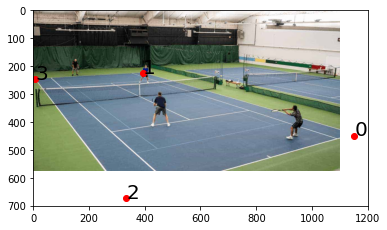

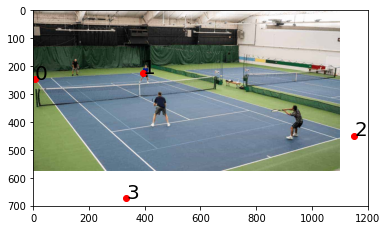

In [104]:
ptt_int = []
for i in range(2):
    for j in range(2,4):
        print(j)
        ptt_int.append(get_intersect(borders_filtered[i][0],borders_filtered[i][1],borders_filtered[j][0],borders_filtered[j][1]))
for j, i in enumerate(ptt_int):
    plt.scatter(i[1],i[0], c = 'r',s=36)
    plt.text(i[1],i[0],s=str(j) ,fontsize=20)
plt.imshow(im)
plt.gca().set_ylim(700)
plt.gca().set_xlim(0,1200)

box = order_points3(np.array(ptt_int))

plt.figure(222)
for j, i in enumerate(box):
    plt.scatter(i[1],i[0], c = 'r',s=36)
    plt.text(i[1],i[0],s=str(j) ,fontsize=20)
plt.imshow(im)
plt.gca().set_ylim(700)
plt.gca().set_xlim(0,1200)

In [125]:
print(box)
# print(box[:,1],box[:,0])
box[:,[0,1]]= box[:,[1,0]]
print(box)

[[ 245.72836      7.2401114]
 [ 225.37599    393.10037  ]
 [ 449.0295    1150.9773   ]
 [ 672.30194    334.72403  ]]
[[   7.2401114  245.72836  ]
 [ 393.10037    225.37599  ]
 [1150.9773     449.0295   ]
 [ 334.72403    672.30194  ]]


In [103]:
def rotate90Clockwise(A):
    N = len(A[0])
    for i in range(N // 2):
        for j in range(i, N - i - 1):
            temp = A[i][j]
            A[i][j] = A[N - 1 - j][i]
            A[N - 1 - j][i] = A[N - 1 - i][N - 1 - j]
            A[N - 1 - i][N - 1 - j] = A[j][N - 1 - i]
            A[j][N - 1 - i] = temp
    return A

In [122]:
def rotate_matrix( m ):
    return np.array([[m[j][i] for j in range(len(m))] for i in range(len(m[0])-1,-1,-1)])

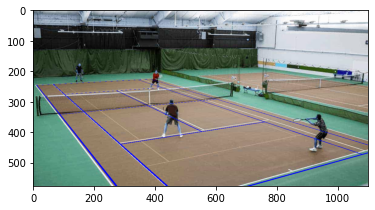

In [126]:
im6 = np.copy(im)
T, status = cv2.findHomography(template_try, np.asarray(box))
court = add_court_overlay(im6, T, overlay_color=(255, 0, 0))
court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", court)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(court)
plt.show()
plt.close()

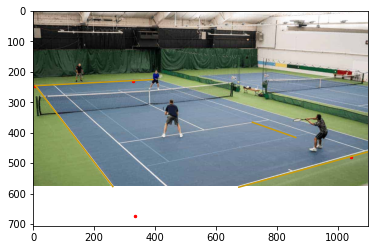

In [80]:
intersections1 = []
box1 = [l1,l3,l2,l4]
for i, vert in enumerate(target_lines[0]):
    if(i == l1 or i == l2):
        for j, hor in enumerate(target_lines[1]):
            if(j == l3 or j == l4):
                ptt2 = get_intersect(vert[0],vert[1],hor[0],hor[1])
                intersections1.append(ptt2)
                plt.scatter(ptt2[1],ptt2[0], c = 'r',s=6)
# plt.gca().invert_yaxis()
plt.imshow(im)

for i, vert in enumerate(target_lines[0]):
    if(i == l1 or i == l2):
        plt.plot((vert[0][1], vert[1][1]),(vert[0][0], vert[1][0] ), c=cc)
for j, hor in enumerate(target_lines[1]):
    if(j == l3 or j == l4):
        plt.plot((hor[0][1], hor[1][1]),(hor[0][0], hor[1][0] ), c=cc)

In [81]:
def order_points(pts):
    # initialize a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype="float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum

	s = pts.sum(axis=1)
	diff = np.diff(pts, axis=1)
	pt1= np.argmin(s)
	pt2= np.argmin(diff)
	rect[0] = pts[pt1]
	rect[1] = pts[pt2]
	# print(pts.shape)
	# print('pts',pts,'rect0',rect[0],'end')
	# print('pts reshape', pts.reshape(-1,1))
	# print(pts.reshape(-1,1).shape)
	# print('rect0 ', rect[0].shape)
	# print('rect0 reshape ', rect[0].reshape(-1,1).shape)
	D1 = dist.cdist(rect[0].reshape(-1,2),pts, "euclidean")
	print('D1', D1)
	pt3 = np.argmax(D1)
	print('argmax ', pt3)
	rect[2] = pts[pt3]

	D2 = dist.cdist(rect[1].reshape(-1,2),pts, "euclidean")
	D3 = dist.cdist(rect[2].reshape(-1,2),pts, "euclidean")
	
	print('D2', D2)
	D4 = D2*D3
	D4 = np.delete(D4,[pt1,pt2,pt3])
	# D3 = np.delete(D3,pt2)
	print('argmax ', np.argmax(D4))
	rect[3] = pts[np.argmax(D4)]
	# # now, compute the difference between the points, the
	# # top-right point will have the smallest difference,
	# # whereas the bottom-left will have the largest difference

	# rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [82]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

In [83]:
def order_points2(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost, rightMost = split_list(xSorted)
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :][-2:]
    (tl, bl) = leftMost
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :][-2:]
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    print(tl,tr,br,bl)
    return np.array([tl, tr, br, bl], dtype="float32")

D1 [[3.80453193e+02 7.02700163e+02 5.72672727e+02 2.14986108e+02
  8.87323392e+02 7.01236903e+02 3.21275249e+02 3.14659967e+02
  5.19119965e+02 8.72337536e+02 7.34341236e+02 3.21888903e+02
  1.06119476e+03 8.69600902e+02 4.47876385e+02 4.44583076e+02
  2.23988221e+02 5.05154858e+02 3.87671413e+02 9.46412784e+01
  6.79805255e+02 5.04860749e+02 1.77420242e+02 1.69024490e+02
  1.77543483e+02 4.47291867e+02 3.33624349e+02 5.64294131e+01
  6.18676679e+02 4.47297994e+02 1.33850836e+02 1.25044665e+02
  5.51638108e+02 9.12235650e+02 7.72517502e+02 3.46225933e+02
  1.10174206e+03 9.09151324e+02 4.77202604e+02 4.74954615e+02
  5.55781389e+02 9.22101307e+02 7.80674583e+02 3.45189230e+02
  1.11307062e+03 9.18901823e+02 4.79594150e+02 4.77390756e+02
  1.18559836e+02 3.71131287e+02 2.63328599e+02 3.40106559e-06
  5.37783162e+02 3.71553882e+02 7.85795015e+01 6.91466095e+01
  5.13367146e+02 8.68548898e+02 7.29820948e+02 3.14837961e+02
  1.05827541e+03 8.65828532e+02 4.41793769e+02 4.38246817e+02
  6.0

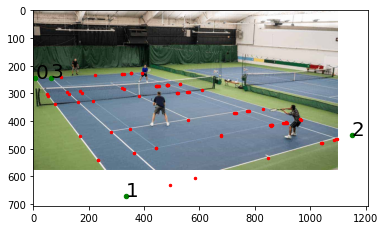

In [84]:
x_max, x_min = -math.inf, math.inf
y_max, y_min = -math.inf, math.inf
intersections = []
box = [[],[],[],[]]
for hor in target_lines[0]:
    for vert in target_lines[1]:
         ptt2 = get_intersect(hor[0],hor[1],vert[0],vert[1])
         if x_max <= ptt2[0]:
            x_max = ptt2[0]
         if x_min >= ptt2[0]:
            x_min = ptt2[0]
         if y_max <= ptt2[1]:
            y_max = ptt2[1]
         if y_min >= ptt2[1]:
            y_min = ptt2[1]
         intersections.append(ptt2)
         plt.scatter(ptt2[1],ptt2[0], c = 'r',s=6)
plt.imshow(im)
# plt.gca().set_ylim(-10,700)
# plt.gca().set_xlim(-100,1200)
# plt.gca().invert_yaxis()

box = order_points(np.array(intersections))
# box[0] = sorted(intersections, key=lambda p: (p[0]) + (p[1]))[0]  # find upper left point
# box[1] = sorted(intersections, key=lambda p: (p[0]) - (p[1]))[-1]  # find upper right point

# high_1 , high_2 = -math.inf, -math.inf
# for inter in intersections:
#    if inter not in (box[0],box[1]):
#       pt1_dist = np.linalg.norm(np.array(box[0])-np.array(inter))
#       pt2_dist = np.linalg.norm(np.array(box[1])-np.array(inter))
#       if pt1_dist >= high_1:
#          high_1 = pt1_dist
#          box[2] = inter
#       if pt2_dist >= high_2:
#          high_2 = pt2_dist
#          box[3] = inter      
      
# print(high_1, high_2)     
# plt.scatter(box[2][1],box[2][0],c='g',s = 30)
for i,j in enumerate(box):
   plt.scatter(j[1],j[0],c='g',s=20)
   plt.text(j[1],j[0],str(i),fontsize=20)


In [85]:
box

array([[ 245.72836  ,    7.2401114],
       [ 672.30194  ,  334.72403  ],
       [ 449.0295   , 1150.9773   ],
       [ 242.7561   ,   63.591194 ]], dtype=float32)